In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import xgboost as xgb
import gc
import random
# import cupy as cp
from sklearn.preprocessing import MinMaxScaler
from dask_ml.model_selection import train_test_split
from tqdm.notebook import tqdm
from numba import jit

# dask
import dask.dataframe as dd
from dask import delayed
import dask.array as da

# Pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

train_files = sorted(
    glob("/output.parquet/*.parquet")
)
print("train_files", len(train_files))

train_files 2839


In [2]:
# train = pd.read_parquet(train_files[:1])
train = dd.read_parquet(train_files[:10], chunksize='64MB')

RANDOM_STATE = 42
random.seed(RANDOM_STATE)

In [3]:
train.head()

,sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,train_0,213.806117,222.244454,229.259879,245.743959,258.337482,265.772467,263.978456,254.879872,243.946147,...,-6.132147e-07,1.401824e-06,0.0,349.564325,0.0,2.947672e-12,0.0,0.0,0.0,0.0
1,train_1,213.177430,225.851064,229.663618,246.828333,261.026415,269.078431,267.736565,256.896227,244.169421,...,3.560950e-07,9.984912e-07,0.0,335.204086,0.0,3.138366e-09,0.0,0.0,0.0,0.0
2,train_2,217.105685,220.448106,234.653398,244.422951,254.023818,259.651472,257.709514,251.064513,241.879600,...,1.565672e-06,6.186607e-05,0.0,401.709340,0.0,7.424215e-09,0.0,0.0,0.0,0.0
3,train_3,217.773994,225.611775,234.104091,247.745365,257.411402,263.470947,261.131775,253.303250,242.316814,...,-9.067304e-06,1.020519e-05,0.0,400.230177,0.0,2.534090e-08,0.0,0.0,0.0,0.0
4,train_4,216.349337,230.526083,233.650252,248.196013,262.500730,270.055663,268.863606,258.161645,244.442620,...,1.681596e-06,-6.378779e-06,0.0,321.960470,0.0,3.377415e-10,0.0,0.0,0.0,0.0


In [4]:
train.info()

<class 'dask_expr.DataFrame'>
Columns: 925 entries, sample_id to cam_out_SOLLD
dtypes: float64(924), string(1)

In [5]:
train = train.dropna()
train = train.drop_duplicates()

In [6]:
# train.describe()

In [7]:
# train.dtypes.value_counts()

In [8]:
train.columns[ train.dtypes == 'object' ]

Index([], dtype='object')

In [9]:
train = train.drop(['sample_id'], axis=1)

In [10]:
# size = train.shape

# Preprocessing

In [11]:
@delayed
def remove_outliers(df_in):
    Q1 = df_in.quantile(0.25)
    Q3 = df_in.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    for col in range(0, df_in.shape[1]):
        df_out = df_in[(df_in.iloc[:, col] >= lower_limit[col]) & (df_in.iloc[:, col] <= upper_limit[col])]
    
    # print("number of outliers removed = ", len(df_in)- len(df_out), "\n")
    return df_out

In [12]:
# train = train.head(1000)
train = remove_outliers(train)

In [13]:
all_targets = [
    'ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59',
    'ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59',
    'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59',
    'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59',
    'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59',
    'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59',
    'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD',
]

gc.collect()

0

In [14]:

X = train.drop(columns = all_targets)
y = train[all_targets]

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X.compute(), y.compute(), test_size=0.3, shuffle = False, random_state= RANDOM_STATE)


In [16]:
scaler = MinMaxScaler()
X_train = da.from_array(scaler.fit_transform(X_train))
X_valid = da.from_array(scaler.transform(X_valid))

In [17]:
# feat_cols = ['f'+str(i) for i in range(924)]

In [18]:
# normalised_features = pd.DataFrame(X_train,columns=feat_cols)
# normalised_features.head()

In [19]:
# c = delayed(np.cov)(X_train)

# Plot the covariance matrix
# sns.heatmap(c)
# plt.show()

In [20]:

# def compute_eigen(c):
#     eigenvalues, eigenvectors = np.linalg.eig(c)
#     return eigenvalues, eigenvectors

# eigenvalues, eigenvectors = compute_eigen(c.compute()   )

# print('Eigen values Shape:', eigenvalues.shape)
# print('Eigen Vector Shape:', eigenvectors.shape)

In [21]:
# # Index the eigenvalues in descending order 
# idx = eigenvalues.argsort()[::-1]

# # Sort the eigenvalues in descending order 
# eigenvalues = eigenvalues[idx]

# # sort the corresponding eigenvectors accordingly
# eigenvectors = eigenvectors[:,idx]


In [22]:

# explained_var = cp.cumsum(eigenvalues) / cp.sum(eigenvalues)
# explained_var

In [23]:
# n_components = cp.argmax(explained_var >= 0.95) + 1
# n_components

In [24]:
# def find_n_components(explained_var, threshold=0.9):
#     n_components = np.argmax(explained_var >= threshold) + 1
#     return n_components

# # Create an array of thresholds from 0.6 to 0.95
# thresholds = np.linspace(0.5, 0.98, 20)

# # Calculate the corresponding number of components for each threshold
# n_components_list = [find_n_components(explained_var, t) for t in thresholds]

# # Plot the results
# plt.figure(figsize=(8, 6))
# plt.plot(thresholds, n_components_list, marker='o', linestyle='-', color='b')
# plt.xlabel('Explained Variance Threshold')
# plt.ylabel('Number of Components')
# plt.title('Number of Components vs. Explained Variance Threshold')
# plt.grid(True)
# plt.show()

In [25]:
from sklearn.decomposition import PCA
n_components = 27 # for explained_var >= 0.91 or use 40 for explained_var >= 0.95
pca_train = PCA(n_components=n_components)
principalComponents_X = da.from_array(pca_train.fit_transform(X_train))
principalComponents_valid = da.from_array(pca_train.fit_transform(X_valid))

In [26]:
pc_cols = np.array(['pc'+str(i) for i in range(n_components)])
principal_train_df = dd.from_dask_array(principalComponents_X, columns=pc_cols)
principal_valid_df = dd.from_dask_array(principalComponents_valid, columns=pc_cols)
principal_train_df.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26
0,0.302526,0.281959,-1.421060,-0.426346,0.407255,0.767697,1.614002,-0.573098,0.128043,-0.919841,...,0.051264,-0.125875,-0.016372,-0.128403,-0.078496,0.179085,-0.124270,0.051309,0.103372,0.174178
1,1.390340,-0.496792,-1.452311,-0.405559,0.735053,0.409318,0.602232,0.404186,-0.754187,0.002251,...,0.101323,-0.118937,-0.184172,0.057911,0.658714,-0.088542,0.129314,-0.123092,-0.019326,0.221541
2,0.586901,0.687643,-2.722683,1.652180,0.834572,-0.371018,0.044713,0.202798,0.173697,-1.338533,...,-0.033299,0.000070,-0.142098,0.035399,-0.652186,0.299531,-0.246478,0.485000,-0.020951,-0.463480
3,1.205967,0.189825,-2.483626,1.055568,0.962218,-1.043993,-0.083958,0.237264,0.079225,-0.806660,...,-0.191556,0.043145,-0.435658,0.093835,0.725862,-0.346930,-0.158732,-0.232297,0.105648,0.040785
4,-0.244606,0.905733,-1.751348,0.529240,0.842424,-0.407920,-0.397850,-0.230981,0.472881,0.960708,...,0.755654,-0.111699,0.420318,0.137791,0.177734,-0.327085,-0.076359,-0.103640,-0.150480,-0.006181


In [27]:
print('Explained variation per principal component: {}'.format(pca_train.explained_variance_ratio_))

Explained variation per principal component: [0.41288821 0.11573974 0.11068556 0.07189003 0.04913327 0.04441526
 0.02842926 0.01966136 0.01715163 0.01405386 0.01097062 0.00970282
 0.00831909 0.00747496 0.00558914 0.0049691  0.00445204 0.00399071
 0.00331866 0.00320708 0.00315389 0.00300112 0.00257027 0.00234184
 0.00220446 0.00199053 0.0019442 ]


In [28]:
# import numpy as np
# import matplotlib.pyplot as plt
# from xgboost import XGBRegressor  # or XGBRegressor

# # Load your dataset (X: features, y: target)
# # Initialize and train the XGBoost model
# model = XGBRegressor()  # Change to XGBRegressor for regression
# model.fit(principal_train_df, y_train)

# # Get feature importances
# importances = model.feature_importances_

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(importances)), importances, align='center')
# plt.yticks(range(len(importances)), pc_cols)  # Replace with your feature names
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.title('Feature Importances')
# plt.show()


In [29]:
# from sklearn.metrics import r2_score
# y_pred = model.predict(principal_valid_df)
# r2 = r2_score(y_valid, y_pred)
# print(f"Best r Squared score: {r2:.2f}")

In [30]:

# pc_cols = pc_cols[importances>0.01]
# len(pc_cols)

In [31]:
# principal_train_df = principal_train_df[pc_cols]
# principal_valid_df = principal_valid_df[pc_cols]

In [32]:
scaler = MinMaxScaler()
X_trainpc = scaler.fit_transform(principal_train_df)
X_validpc = scaler.transform(principal_valid_df)

In [33]:
X_validpc, X_testpc, y_validpc, y_testpc = train_test_split(X_validpc, y_valid, test_size=0.3, shuffle = False, random_state= RANDOM_STATE)

In [34]:
X_trainpc.shape

(22517, 27)

In [35]:
type(X_trainpc)

numpy.ndarray

In [36]:
type(y_train)

pandas.core.frame.DataFrame

# Defining model

In [37]:
BATCH_SIZE = 64
NUM_FEATURES = len(pc_cols)
NUM_TARGETS = len(y_train.columns)
NUM_EPOCHS = 100

torch.cuda.manual_seed(RANDOM_STATE)

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:

class Atmos(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

# As you can see we define torch arrays - then we will put them into device
train_dataset = Atmos(torch.from_numpy(X_trainpc).float(), torch.from_numpy(y_train.values).float())
valid_dataset = Atmos(torch.from_numpy(X_validpc).float(), torch.from_numpy(y_validpc.values).float())
test_dataset = Atmos(torch.from_numpy(X_testpc).float(), torch.from_numpy(y_testpc.values).float())

In [40]:
# Data loaders 
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [41]:
# # You can test it if you want - take first batch (size = 16) and print size

# for batch_idx, (train_features, train_labels) in enumerate(train_loader):
#     print(f"Batch #{batch_idx + 1}")
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
#     print("First row from batch")
#     print(train_features[0])

In [42]:
class AtmosRegressionModel(nn.Module):
    def __init__(self, num_feature, num_outputs):
        super(AtmosRegressionModel, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 32)
        self.layer_2 = nn.Linear(32, 16)
        # self.layer_3 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(16, num_outputs)  
        
        torch.nn.init.xavier_normal_(self.layer_1.weight)
        torch.nn.init.xavier_normal_(self.layer_2.weight)
        # torch.nn.init.xavier_normal_(self.layer_3.weight)
        torch.nn.init.xavier_normal_(self.layer_out.weight)
        
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.2)
        
        self.batchnorm_1 = nn.BatchNorm1d(32)
        self.batchnorm_2 = nn.BatchNorm1d(16)
        # self.batchnorm_3 = nn.BatchNorm1d(32)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.dropout_1(x)
        
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.dropout_2(x)
        
        # x = self.layer_3(x)
        # x = self.relu(x)
        # x = self.dropout_2(x)
        
        x = self.layer_out(x) 
        return x


In [43]:
modelMod = AtmosRegressionModel(num_feature = NUM_FEATURES, num_outputs=NUM_TARGETS)
modelMod.to(device)

AtmosRegressionModel(
  (layer_1): Linear(in_features=27, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=368, bias=True)
  (dropout_1): Dropout(p=0.3, inplace=False)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (batchnorm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [44]:
class R2Loss(nn.Module):
    def forward(self, y_pred, y_true):
        # Calculate the R2 score
        SS_res = torch.sum((y_true - y_pred) ** 2)
        SS_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        r2 = SS_res / SS_tot # I have reduced this problem to 1-r2 to make it a minimization problem so now this ratio should be near to 0
        return r2

In [45]:
criterion = R2Loss()    #  nn.MSELoss()
model = modelMod

In [46]:
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)

In [47]:
loss_stat = {'train': [], "validation": [] ,"test": []}

def mse_loss(y_pred, y_test):
    # Calculate Mean Squared Error (MSE)
    loss = nn.MSELoss()(y_pred, y_test)
    return loss.item()

In [48]:
class EarlyStoppingCallback:
    def __init__(self, min_delta=0.1, patience=5):
        self.min_delta = min_delta
        self.patience = patience
        self.best_loss = float('inf')  # Initialize with a large value
        self.attempt = 0
        self.stop_training = False

    def __call__(self, validation_loss):
        if validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.attempt = 0
        else:
            self.attempt += 1
            print(f'Message from callback (Early Stopping) counter: {self.attempt}/{self.patience}')
            if self.attempt >= self.patience:
                self.stop_training = True


In [49]:
def train_nn():
    best_val_loss = float('inf')
    for progress in tqdm(range(1, NUM_EPOCHS + 1)):
        train_epoch_loss = 0

        model.train()

        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            optimizer.zero_grad()
            y_train_pred = model(X_train_batch)

            # Use Mean Squared Error (MSE) for regression
            train_loss = criterion(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()

        with torch.no_grad():
            val_epoch_loss = 0

            model.eval()
            for X_val_batch, y_val_batch in valid_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_epoch_loss += val_loss.item()
                
            test_epoch_loss = 0
            
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
                y_test_pred = model(X_test_batch)

                test_loss = criterion(y_test_pred, y_test_batch)
                test_epoch_loss += test_loss.item()

                if val_epoch_loss < best_val_loss:
                    best_val_loss = val_epoch_loss
                    torch.save(model.state_dict(), 'best_model6.pth')

        early_stopping_callback(val_epoch_loss / len(valid_loader))
        if early_stopping_callback.stop_training:
            print(f'Training stopped -> Early Stopping Callback: validation_loss: {val_epoch_loss / len(valid_loader)}')
            break

        loss_stat['train'].append(train_epoch_loss / len(train_loader))
        loss_stat['validation'].append(val_epoch_loss / len(valid_loader))
        loss_stat['test'].append(test_epoch_loss / len(test_loader))

        clr = optimizer.param_groups[0]['lr']
        scheduler.step(val_epoch_loss / len(valid_loader))

        print(f'Epoch {progress:03}: Loss: [Train: {train_epoch_loss / len(train_loader):.4f} | Validation: {val_epoch_loss / len(valid_loader):.4f} | Testing: {test_epoch_loss / len(test_loader):.4f}] LR: {clr}')


In [50]:
early_stopping_callback = EarlyStoppingCallback(0.001, 3)

# Training

In [51]:
train_nn()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: Loss: [Train: 0.7136 | Validation: 0.3239 | Testing: 0.3333] LR: 0.001
Epoch 002: Loss: [Train: 0.3788 | Validation: 0.3024 | Testing: 0.3102] LR: 0.001
Epoch 003: Loss: [Train: 0.3632 | Validation: 0.2759 | Testing: 0.2811] LR: 0.001
Epoch 004: Loss: [Train: 0.3412 | Validation: 0.2355 | Testing: 0.2380] LR: 0.001
Epoch 005: Loss: [Train: 0.3123 | Validation: 0.1929 | Testing: 0.1943] LR: 0.001
Epoch 006: Loss: [Train: 0.2760 | Validation: 0.1651 | Testing: 0.1675] LR: 0.001
Epoch 007: Loss: [Train: 0.2417 | Validation: 0.1493 | Testing: 0.1535] LR: 0.001
Epoch 008: Loss: [Train: 0.2091 | Validation: 0.1377 | Testing: 0.1425] LR: 0.001
Epoch 009: Loss: [Train: 0.1786 | Validation: 0.1267 | Testing: 0.1313] LR: 0.001
Epoch 010: Loss: [Train: 0.1554 | Validation: 0.1162 | Testing: 0.1203] LR: 0.001
Epoch 011: Loss: [Train: 0.1353 | Validation: 0.1072 | Testing: 0.1107] LR: 0.001
Epoch 012: Loss: [Train: 0.1220 | Validation: 0.1000 | Testing: 0.1029] LR: 0.001
Epoch 013: Loss:

In [52]:
df_train_vl = pd.DataFrame.from_dict(loss_stat).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

Text(0.5, 1.0, 'Train - Validation Loss/Epoch')

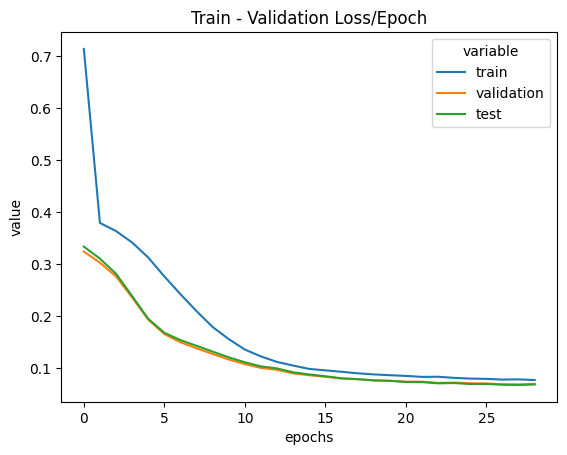

In [53]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data = df_train_vl, x = "epochs", y="value", hue="variable").set_title('Train - Validation Loss/Epoch')